In [5]:
# Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
import dlib
import face_recognition
import random
from PIL import Image

# Define transforms for both training and testing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the paths to the train and test data directories
train_data_dir = 'Dataset/train/' 
test_data_dir = 'Dataset/test/'    

# Load train and test datasets using ImageFolder
train_dataset = ImageFolder(root=train_data_dir, transform=transform)
test_dataset = ImageFolder(root=test_data_dir, transform=transform)

# Define batch size for dataloaders
batch_size = 32

# Create dataloaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(train_loader.dataset.classes)
print(test_loader.dataset.classes)
classes = train_dataset.classes
print(len(classes))
# Load pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# Freeze all layers except the last fully connected layer
for param in resnet.parameters():
    param.requires_grad = False

# Modify the last fully connected layer for binary classification (2 output classes)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(train_loader.dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

['13020220048', '13020220049', '13020220050', '13020220051', '13020220052', '13020220053', '13020220054', '13020220056', '13020220148', '13020220152', '13020220155', '13020220157', '13020220159', '13020220160', '13020220167', '13020220173', '13020220303', '13020220304', '13020220305']
['13020220048', '13020220049', '13020220050', '13020220051', '13020220052', '13020220053', '13020220054', '13020220056', '13020220148', '13020220152', '13020220155', '13020220157', '13020220159', '13020220160', '13020220167', '13020220173', '13020220303', '13020220304', '13020220305']
19


d:\Data Science\FRP\AttendanceFaceRecognition\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Data Science\FRP\AttendanceFaceRecognition\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


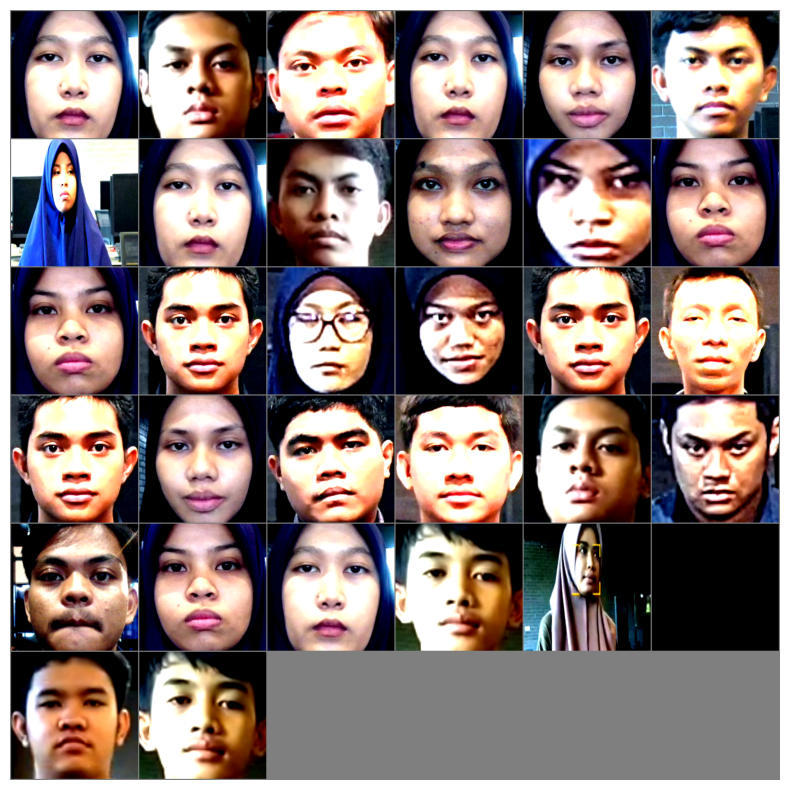

13020220167 13020220305 13020220053 13020220167 13020220157 13020220304 13020220173 13020220167 13020220304 13020220155 13020220173 13020220173 13020220173 13020220050 13020220167 13020220148 13020220050 13020220056 13020220050 13020220157 13020220049 13020220048 13020220305 13020220305 13020220053 13020220173 13020220167 13020220303 13020220152 13020220157 13020220051 13020220303


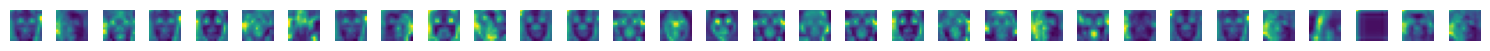

In [8]:
# Visualize data and features

# Define a function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Show images
imshow(torchvision.utils.make_grid(images, nrow=int(np.ceil(np.sqrt(len(images))))))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))


# Forward pass the images through the model
resnet.eval()
with torch.no_grad():
    features = resnet.conv1(images)
    for name, module in resnet.layer1.named_children():
        features = module(features)
    for name, module in resnet.layer2.named_children():
        features = module(features)
    for name, module in resnet.layer3.named_children():
        features = module(features)
    for name, module in resnet.layer4.named_children():
        features = module(features)

# Visualize the features (assuming features is a tensor)
# Reshape the features tensor to (batch_size, num_channels, height, width)
features = features.view(batch_size, -1, features.shape[-2], features.shape[-1])

# Take the mean along the channel dimension to get a single feature map for each image
mean_features = torch.mean(features, dim=1)

# Set the figure size
plt.figure(figsize=(15, 5))

# Plot the mean feature map for each image
for i in range(batch_size):
    plt.subplot(1, batch_size, i+1)
    plt.imshow(mean_features[i].cpu().numpy(), cmap='viridis')
    plt.axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [11]:
# List metrics
train_loss_history = []
test_loss_history = []
accuracy_history = []

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Train and validation loop
for epoch in range(num_epochs):
    # Training loop
    resnet.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)

    # Validation loop
    resnet.eval()
    correct = 0
    total = 0
    test_running_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(test_loader)
    test_loss_history.append(test_loss)

    # Calculate accuracy
    accuracy = 100 * correct / total
    accuracy_history.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%")

Epoch [1/10], Training Loss: 2.0509, Validation Loss: 1.3842, Accuracy: 73.87%
Epoch [2/10], Training Loss: 1.1599, Validation Loss: 0.9254, Accuracy: 83.88%
Epoch [3/10], Training Loss: 0.8533, Validation Loss: 0.7261, Accuracy: 86.78%
Epoch [4/10], Training Loss: 0.6933, Validation Loss: 0.6063, Accuracy: 89.15%
Epoch [5/10], Training Loss: 0.5938, Validation Loss: 0.5277, Accuracy: 89.92%
Epoch [6/10], Training Loss: 0.5209, Validation Loss: 0.4721, Accuracy: 91.29%
Epoch [7/10], Training Loss: 0.4715, Validation Loss: 0.4340, Accuracy: 92.44%
Epoch [8/10], Training Loss: 0.4354, Validation Loss: 0.3960, Accuracy: 92.59%
Epoch [9/10], Training Loss: 0.3942, Validation Loss: 0.3661, Accuracy: 93.28%
Epoch [10/10], Training Loss: 0.3656, Validation Loss: 0.3465, Accuracy: 93.05%


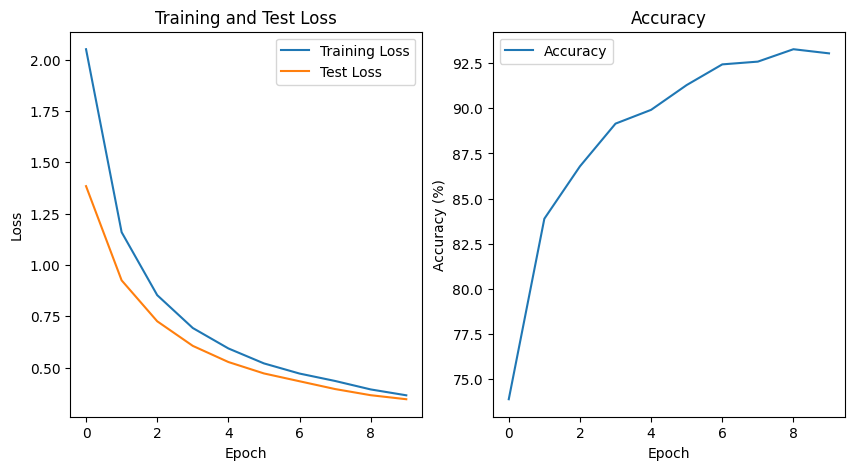

In [12]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

plt.show()

In [13]:
# Save the trained model
torch.save(resnet.state_dict(), 'resnet_model.pth')

In [9]:
# Create Similarity Dataset

# Define paths
dataset_root = 'Eval_dataset'
metadata_file = 'metadata.csv'

# Create dataset root directory
if not os.path.exists(dataset_root):
    os.makedirs(dataset_root)

# Function to generate similar pairs
def generate_similar_pairs(person_folders):
    similar_pairs = []
    for folder in person_folders:
        images = os.listdir(os.path.join(dataset_root, folder))
        for i, img1 in enumerate(images):
            for j, img2 in enumerate(images):
                if i < j:
                    similar_pairs.append((os.path.join(folder, img1), os.path.join(folder, img2), 1))
    return similar_pairs

# Function to generate dissimilar pairs
def generate_dissimilar_pairs(person_folders):
    dissimilar_pairs = []
    for i, folder1 in enumerate(person_folders):
        for j, folder2 in enumerate(person_folders):
            if i < j:
                images1 = os.listdir(os.path.join(dataset_root, folder1))
                images2 = os.listdir(os.path.join(dataset_root, folder2))
                for img1 in images1:
                    for img2 in images2:
                        dissimilar_pairs.append((os.path.join(folder1, img1), os.path.join(folder2, img2), 0))
    return dissimilar_pairs

# Get list of person folders
person_folders = os.listdir(dataset_root)

# Generate pairs
similar_pairs = generate_similar_pairs(person_folders)
dissimilar_pairs = generate_dissimilar_pairs(person_folders)

# Combine pairs and shuffle
pairs = similar_pairs + dissimilar_pairs
random.shuffle(pairs)

# Write metadata to CSV file
with open(metadata_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image1_Path', 'Image2_Path', 'Label'])
    for pair in pairs:
        writer.writerow(pair)

print(f"Dataset folder structure and metadata file generated successfully!")

Dataset folder structure and metadata file generated successfully!


In [10]:
# Evaluate finetuned model

# Load the fine-tuned ResNet model
loaded_model = models.resnet50(pretrained=False)  # Instantiate the same architecture
loaded_model.fc = nn.Linear(num_ftrs, len(train_loader.dataset.classes)) 
loaded_model.load_state_dict(torch.load('resnet_model.pth'))
loaded_model.eval()  # Set the model to evaluation mode
correct_predictions = 0  # Initialize the variable to count correct predictions

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess image
def load_image(image_path):
    image = Image.open(image_path)
    image = transform(image)
    return image.unsqueeze(0)  # Add batch dimension

# Load metadata CSV file
metadata_file = 'Metadata.csv'
with open(metadata_file, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        image1_path = row['Image1_Path']
        image2_path = row['Image2_Path']
        label = int(row['Label'])

        # Load and preprocess images
        image1 = load_image(os.path.join('Eval_dataset', image1_path))
        image2 = load_image(os.path.join('Eval_dataset', image2_path))

        # Generate embeddings
        with torch.no_grad():
            embedding1 = resnet(image1)
            embedding2 = resnet(image2)

        # Compute similarity score (cosine similarity)
        similarity_score = torch.nn.functional.cosine_similarity(embedding1, embedding2, dim=1).item()

        # Classify as similar (1) or dissimilar (0) based on threshold
        threshold = 0.5  # Set your threshold here
        prediction = 1 if similarity_score >= threshold else 0

        # Compare with ground truth label and compute evaluation metrics
        if prediction == label:
            correct_predictions += 1

# Compute evaluation metrics
total_pairs = len(pairs)
accuracy = correct_predictions / total_pairs
# Compute other evaluation metrics as needed

print(f"Accuracy: {accuracy}")
# Print other evaluation metrics

Accuracy: 0.6575718153370135


In [12]:
# Evaluate baseline

# Load metadata CSV file
metadata_file = 'Metadata.csv'
correct_predictions = 0  # Initialize the variable to count correct predictions

# Initialize face detector and face recognition model
detector = dlib.get_frontal_face_detector()
face_recog_model = 'hog'  # 'hog' for CPU-based model, 'cnn' for GPU-based model

with open(metadata_file, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        image1_path = row['Image1_Path']
        image2_path = row['Image2_Path']
        label = int(row['Label'])

        # Load images
        image1 = face_recognition.load_image_file(os.path.join('Eval_dataset', image1_path))
        image2 = face_recognition.load_image_file(os.path.join('Eval_dataset', image2_path))

        # Detect faces and extract embeddings
        face_locations1 = face_recognition.face_locations(image1, model=face_recog_model)
        face_locations2 = face_recognition.face_locations(image2, model=face_recog_model)
        
        if len(face_locations1) > 0 and len(face_locations2) > 0:
            face_encoding1 = face_recognition.face_encodings(image1, face_locations1)[0]
            face_encoding2 = face_recognition.face_encodings(image2, face_locations2)[0]

            # Compute similarity score (e.g., Euclidean distance)
            similarity_score = face_recognition.face_distance([face_encoding1], face_encoding2)[0]

            # Classify as similar (1) or dissimilar (0) based on threshold
            threshold = 0.5  # Set your threshold here
            prediction = 1 if similarity_score <= threshold else 0

            # Compare with ground truth label and compute evaluation metrics
            if prediction == label:
                correct_predictions += 1

            total_pairs += 1

# Compute evaluation metrics
accuracy = correct_predictions / total_pairs

print(f"Accuracy: {accuracy}")

Accuracy: 0.4673001577818356
